# Forecasting de la generación fotovoltaica con Redes LSTM

## 1. Preparación y análisis de los datos

### Datos meteorológicos de La Laguna

Combinamos cada uno de los archivos de datos meteorológicos. En este caso, se renombra cada una de las columnas para estandarizarlas y además se convierte la columna Fecha y hora al formato datetime ya que en algunos archivos la fecha no se encuentra en el formato adecuado, lo que no permite procesar los datos.

In [1]:
import pandas as pd
import os

# Define la ruta al directorio con los archivos Excel.
path_to_excel = r'C:\Users\angel\Desktop\MASTER\TFM\DATOS_METEOROLOGICOS' 
dataframes_list = []

# Itera sobre todos los archivos en el directorio
for file in os.listdir(path_to_excel):
    # Comprueba si el archivo es un archivo Excel
    if file.endswith(('.xlsx', '.xls')):
        # Construye la ruta completa al archivo
        file_path = os.path.join(path_to_excel, file)
        try:
            # Intenta leer el archivo Excel, utilizando la segunda fila como cabecera.
            df = pd.read_excel(file_path, header=1)
            # Verifica que el archivo tenga el número correcto de columnas
            if len(df.columns) == 5:
                # Renombra las columnas para estandarizarlas
                df.columns = ['Fecha y hora', 'Temperatura', 'Humedad', 'Velocidad viento', 'Radiación']
                # Intenta convertir la columna 'Fecha y hora' al formato datetime.
                try:
                    df['Fecha y hora'] = pd.to_datetime(df['Fecha y hora'], format='%d/%m/%Y %H:%M')
                except ValueError:
                    # Si hay un error de formato, deja el paso de conversión y continúa
                    pass
                
                # Después de intentar la conversión, verifica si hay valores NaT (no se pudo convertir)
                if df['Fecha y hora'].isnull().any():
                    print(f"Advertencia: Algunas fechas no se pudieron parsear en {file}.")
                    # Imprime las filas donde la conversión falló.
                    problematic_values = df[df['Fecha y hora'].isnull()]['Fecha y hora']
                    print(problematic_values)

                # Añade el DataFrame procesado a la lista
                dataframes_list.append(df)
            else:
                # Imprime un mensaje si el archivo no tiene el número esperado de columnas
                print(f"El archivo {file} no tiene el número esperado de columnas.")
        except Exception as e:
            # Captura cualquier otro error durante el procesamiento del archivo y lo imprime
            print(f"Error al procesar el archivo {file}: {e}")

# Comprueba si se agregaron DataFrames a la lista
if dataframes_list:
    # Combina todos los DataFrames en uno solo
    df_meteorological = pd.concat(dataframes_list, ignore_index=True)
    # Ordena el DataFrame combinado por la columna 'Fecha y hora'
    df_meteorological.sort_values('Fecha y hora', inplace=True)
    # Guarda el DataFrame combinado en un nuevo archivo Excel
    df_meteorological.to_excel(r'C:\Users\angel\Desktop\MASTER\TFM\combined_meteorological_data.xlsx', index=False)
else:
    # Imprime un mensaje si no se encontraron archivos válidos para combinar
    print("No se encontraron archivos válidos para combinar.")

El archivo TF164-050420242005.xls no tiene el número esperado de columnas.


Entendemos la estructura del archivo de datos

In [2]:
# Cargar el archivo Excel
file_path = 'C:/Users/angel/Desktop/MASTER/TFM/combined_meteorological_data.xlsx'
data = pd.read_excel(file_path)

# Mostrar las primeras filas para entender la estructura de los datos
data.head(), data.dtypes

(         Fecha y hora Temperatura Humedad Velocidad viento Radiación
 0 2023-03-28 00:00:00       19,90    0,70             0,70      0,00
 1 2023-03-28 00:00:00       19,90    0,70             0,70      0,00
 2 2023-03-28 00:30:00       20,80    0,70             0,37      0,00
 3 2023-03-28 00:30:00       20,80    0,70             0,37      0,00
 4 2023-03-28 01:00:00       20,13    0,70             0,73      0,00,
 Fecha y hora        datetime64[ns]
 Temperatura                 object
 Humedad                     object
 Velocidad viento            object
 Radiación                   object
 dtype: object)

Convertimos la columnas Temperatura, Humedad, Velocidad viento y Radiación a valores numéricos reempleazando las comas por puntos para manejar correctamente los decimales

In [3]:
# Convertir las columnas a valores numéricos, reemplazando comas por puntos
data['Temperatura'] = data['Temperatura'].str.replace(',', '.').astype(float)
data['Humedad'] = data['Humedad'].str.replace(',', '.').astype(float)
data['Velocidad viento'] = data['Velocidad viento'].str.replace(',', '.').astype(float)
data['Radiación'] = data['Radiación'].str.replace(',', '.').astype(float)

# Revisar los cambios
data.dtypes

Fecha y hora        datetime64[ns]
Temperatura                float64
Humedad                    float64
Velocidad viento           float64
Radiación                  float64
dtype: object

Filtramos los datos para un año

In [4]:
# Filtrar los datos para quedarse solo con los del rango especificado
start_date = '2023-04-04'
end_date = '2024-04-04'

filtered_data = data[(data['Fecha y hora'] >= start_date) & (data['Fecha y hora'] <= end_date)]

# Verificar los extremos del rango de fechas en los datos filtrados
filtered_data['Fecha y hora'].min(), filtered_data['Fecha y hora'].max(), filtered_data.shape

(Timestamp('2023-04-04 00:00:00'),
 Timestamp('2024-04-04 00:00:00'),
 (19924, 5))

Eliminamos las fechas duplicadas y verificamos si hay fechas que no disponen de datos

In [5]:
import pandas as pd

# Eliminar datos duplicados basándonos en 'Fecha y hora'
filtered_data_unique = filtered_data.drop_duplicates(subset=['Fecha y hora'])

# Generar rango de fechas con una frecuencia de 30 minutos
all_dates_half_hourly = pd.date_range(start='2023-04-04', end='2024-04-04', freq='30min')

# Convertir las marcas de tiempo en tus datos a solo fecha (para facilitar la agrupación por día)
data_dates = filtered_data_unique['Fecha y hora'].dt.date.unique()

# Convertir el rango de fechas completo a solo fecha (para comparación)
all_dates = all_dates_half_hourly.date

# Identificar las fechas faltantes (ignorando las horas)
missing_dates = pd.to_datetime([date for date in all_dates if date not in data_dates])

# Contar cuántas marcas de tiempo faltan por cada fecha
missing_counts = missing_dates.to_series().dt.date.value_counts().sort_values(ascending=False)

# Mostrar las fechas con más datos faltantes
print("Fechas con mayor cantidad de datos faltantes:")
print(missing_counts)

Fechas con mayor cantidad de datos faltantes:
2024-02-27    48
dtype: int64


Completamos el dataset creando filas con las fechas faltantes y los completamos con su valor medio

In [15]:
import numpy as np

# Calcula los valores medios para las columnas numéricas
mean_values = filtered_data_unique[['Temperatura', 'Humedad', 'Velocidad viento', 'Radiación']].mean()

# Generar rango de fechas con una frecuencia de 30 minutos
all_dates_half_hourly = pd.date_range(start='2023-04-04', end='2024-04-04', freq='30min')

# Verifica y completa las marcas de tiempo faltantes, coger mejor los datos del día anterior
for datetime in all_dates_half_hourly:
    if datetime not in filtered_data_unique['Fecha y hora'].values:
        # Crea una nueva fila con los valores medios y la fecha faltante
        new_row = {'Fecha y hora': datetime, 'Temperatura': mean_values['Temperatura'], 'Humedad': mean_values['Humedad'], 'Velocidad viento': mean_values['Velocidad viento'], 'Radiación': mean_values['Radiación']}
        # Añade la nueva fila al DataFrame
        filtered_data_unique = filtered_data_unique.concat(new_row, ignore_index=True)

# Ordena el DataFrame por 'Fecha y hora' después de añadir las nuevas filas
filtered_data_unique.sort_values(by='Fecha y hora', inplace=True)

# Revisa el DataFrame resultante
print(filtered_data_unique.head())

         Fecha y hora  Temperatura  Humedad  Velocidad viento  Radiación
0 2023-04-04 00:00:00        14.37    85.87              7.33        0.0
1 2023-04-04 00:30:00        14.20    91.20              8.10        0.0
2 2023-04-04 01:00:00        14.07    92.03              7.90        0.0
3 2023-04-04 01:30:00        14.23    91.57              7.40        0.0
4 2023-04-04 02:00:00        14.30    86.63              7.13        0.0


Guardamos el archivo resultante con sus modificaciones

In [14]:
# Guardar los cambios en un nuevo archivo Excel
output_meteorological_file_path = 'C:/Users/angel/Desktop/MASTER/TFM/meteorological_data_cleaned.xlsx'
filtered_data_unique.to_excel(output_meteorological_file_path, index=False)

print("Datos guardados exitosamente en:", output_meteorological_file_path)

Datos guardados exitosamente en: C:/Users/angel/Desktop/MASTER/TFM/meteorological_data_cleaned.xlsx


### Datos de consumo y generación del Ed. SEGAI

Combinamos cada uno de los archivos de datos que disponen la información de la planta fotovoltaica del Ed. SEGAI

In [8]:
import pandas as pd
import os

# Ruta donde tenemos los archivos Excel
ruta = 'C:\\Users\\angel\\Desktop\\MASTER\\TFM\\DATOS_SEGAI'

# Lista para almacenar los dataframes
dataframes = []

# Mapeo de nombres alternativos de columnas a nombres estándar
mapeo_nombres_columnas = {
    'Tiempo': 'Time',
    'FV(W)': 'PV(W)',
    'Medidor(W)': 'Meter(W)',
    'Carga(W)': 'Load(W)',
}

# Recorrer cada archivo en el directorio especificado
for archivo in os.listdir(ruta):
    if archivo.endswith('.xlsx') or archivo.endswith('.xls'):  # Verifica la extensión del archivo
        # Construir el path completo del archivo
        archivo_completo = os.path.join(ruta, archivo)
        try:
            # Leer el archivo Excel, considerando que la tercera fila contiene el encabezado
            df = pd.read_excel(archivo_completo, header=2)
            # Renombrar las columnas usando el mapeo
            df.rename(columns=mapeo_nombres_columnas, inplace=True)
            # Verificamos que las columnas renombradas existen ahora en el dataframe
            if not all(col in df.columns for col in mapeo_nombres_columnas.values()):
                missing = list(set(mapeo_nombres_columnas.values()) - set(df.columns))
                print(f'Al archivo {archivo} le faltan las columnas {missing} después de renombrar.')
                continue
            # Seleccionar solo las columnas estandarizadas
            df = df[list(mapeo_nombres_columnas.values())]
            # Convertir la columna 'Time' al tipo de dato correcto para fecha y hora
            df['Time'] = pd.to_datetime(df['Time'])
            # Añadir el dataframe a la lista
            dataframes.append(df)
        except Exception as e:
            print(f'Error al procesar el archivo {archivo}: {e}')

# Combinar todos los dataframes en uno solo
df_combinado = pd.concat(dataframes, ignore_index=True)

# Ordenamos el dataframe por la columna 'Time'
df_combinado.sort_values('Time', inplace=True)

# Agrupamos los datos en intervalos de 30 minutos y calculamos el promedio
df_combinado = df_combinado.set_index('Time').resample('30T').mean().reset_index()

# Guardar el dataframe combinado en un nuevo archivo Excel
ruta_salida = 'C:\\Users\\angel\\Desktop\\MASTER\\TFM\\electrical_combined_data.xlsx'
df_combinado.to_excel(ruta_salida, index=False)

Entendemos la estructura del archivo de datos

In [9]:
# Cargar el archivo Excel
file_path = 'C:/Users/angel/Desktop/MASTER/TFM/electrical_combined_data.xlsx'
data_electrical = pd.read_excel(file_path)

# Mostrar las primeras filas para entender la estructura de los datos
data_electrical.head(), data_electrical.dtypes

(                 Time  PV(W)  Load(W)
 0 2023-03-25 00:00:00    0.0  30182.5
 1 2023-03-25 00:30:00    0.0  38533.5
 2 2023-03-25 01:00:00    0.0  30110.5
 3 2023-03-25 01:30:00    0.0  38651.5
 4 2023-03-25 02:00:00    0.0  30220.0,
 Time       datetime64[ns]
 PV(W)             float64
 Load(W)           float64
 dtype: object)

Filtramos los datos para quedarnos con los datos de un único año al igual que en el caso anterior

In [10]:
# Filtrar los datos para quedarse solo con los del rango especificado
start_date = '2023-04-04'
end_date = '2024-04-04'

filtered_electrical_data = data_electrical[(data_electrical['Time'] >= start_date) & (data_electrical['Time'] <= end_date)]

# Verificar los extremos del rango de fechas en los datos filtrados
print(filtered_electrical_data['Time'].min(), filtered_electrical_data['Time'].max(), filtered_electrical_data.shape)

2023-04-04 00:00:00 2024-04-04 00:00:00 (17569, 3)


Eliminamos los datos duplicados basandonos en la columna Fecha y obtenemos las fechas con valores faltantes

In [11]:
# Eliminar filas duplicadas basadas en la columna 'Time' en los datos filtrados
filtered_electrical_data = filtered_electrical_data.drop_duplicates(subset='Time')

# Establecer la columna 'Time' como índice para el DataFrame filtrado
filtered_electrical_data.set_index('Time', inplace=True)

# Contar valores nulos por fecha (ignorando la hora)
null_counts_by_date = filtered_electrical_data.isnull().resample('D').sum()

# Obtener las fechas donde hay al menos un valor nulo
dates_with_missing_data = null_counts_by_date[null_counts_by_date.sum(axis=1) > 0]

# Mostrar las fechas y la cantidad de datos que faltan por cada columna
print(dates_with_missing_data)

            PV(W)  Load(W)
Time                      
2023-10-03     48       48
2023-10-04     48       48


Completamos esos datos faltantes realizando una interpolación lineal

In [12]:
# Interpolación lineal para completar datos faltantes
columns_to_interpolate = ['PV(W)', 'Load(W)']  

for column in columns_to_interpolate:
    filtered_electrical_data[column] = filtered_electrical_data[column].interpolate(method='linear')

# Verificar que no hay datos faltantes
print('Cantidad de NaNs:')
for column in filtered_electrical_data:
    nans = filtered_electrical_data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna PV(W): 0
	Columna Load(W): 0


Guardamos el archivo resultante con sus modificaciones

In [13]:
# Guardar los cambios en un nuevo archivo Excel
output_file_path = 'C:/Users/angel/Desktop/MASTER/TFM/electrical_data_cleaned.xlsx'
filtered_electrical_data.reset_index().to_excel(output_file_path, index=False)

print("Datos guardados exitosamente en:", output_file_path)

Datos guardados exitosamente en: C:/Users/angel/Desktop/MASTER/TFM/electrical_data_cleaned.xlsx


### Combinación de los datos Meteorológicos y Eléctricos

Uniremos los DataFrames en base a la columna de fecha y hora común

In [16]:
# Cargar los datos eléctricos y meteorológicos
electrical_data_path = 'C:/Users/angel/Desktop/MASTER/TFM/electrical_data_cleaned.xlsx'
meteorological_data_path = 'C:/Users/angel/Desktop/MASTER/TFM/meteorological_data_cleaned.xlsx'

electrical_data = pd.read_excel(electrical_data_path)
meteorological_data = pd.read_excel(meteorological_data_path)

# Convertir las columnas de fecha y hora a datetime aunque anteriormente hayan sido convertidas para asegurar
meteorological_data['Fecha y hora'] = pd.to_datetime(meteorological_data['Fecha y hora'])
electrical_data['Time'] = pd.to_datetime(electrical_data['Time'])

# Renombrar la columna de tiempo en el dataframe eléctrico para que coincida con el archivo de datos meteorológico
electrical_data.rename(columns={'Time': 'Fecha y hora'}, inplace=True)

# Unir los dataframes en la columna de fecha y hora común
combined_data = pd.merge(meteorological_data, electrical_data[['Fecha y hora', 'PV(W)', 'Load(W)']],
                         on='Fecha y hora', how='left')

# Verificar los primeros registros para asegurarse de que la unión es correcta
print(combined_data.head())

# Guardar el dataframe combinado en un nuevo archivo Excel
combined_data_path = 'C:/Users/angel/Desktop/MASTER/TFM/combined_data.xlsx'
combined_data.to_excel(combined_data_path, index=False)

print("Datos combinados guardados exitosamente en:", combined_data_path)

         Fecha y hora  Temperatura  Humedad  Velocidad viento  Radiación  \
0 2023-04-04 00:00:00        14.37    85.87              7.33        0.0   
1 2023-04-04 00:30:00        14.20    91.20              8.10        0.0   
2 2023-04-04 01:00:00        14.07    92.03              7.90        0.0   
3 2023-04-04 01:30:00        14.23    91.57              7.40        0.0   
4 2023-04-04 02:00:00        14.30    86.63              7.13        0.0   

   PV(W)       Load(W)  
0    0.0  33387.333333  
1    0.0  23725.333333  
2    0.0  24043.833333  
3    0.0  23196.500000  
4    0.0  22820.833333  
Datos combinados guardados exitosamente en: C:/Users/angel/Desktop/MASTER/TFM/combined_data.xlsx


Verificamos nuevamente si existen datos faltantes

In [17]:
# Contar los valores faltantes (NaN) en cada columna
missing_values_count = combined_data.isnull().sum()

# Mostrar la cantidad de datos faltantes por columna
print('Cantidad de datos faltantes por columna:')
print(missing_values_count)

# Verificar si hay alguna fila completa con datos faltantes
complete_missing_rows = combined_data.isnull().all(axis=1).sum()
print(f'\nNúmero total de filas con todos los datos faltantes: {complete_missing_rows}')

Cantidad de datos faltantes por columna:
Fecha y hora         0
Temperatura         19
Humedad             19
Velocidad viento    19
Radiación           19
PV(W)                0
Load(W)              0
dtype: int64

Número total de filas con todos los datos faltantes: 0


Se puede observar que hay diferentes columnas que tienen datos faltantes. Posteriormente realizaremos el manejo de estos datos

Verificamos si hay datos duplicados en la columna Fecha y Hora y además, garantizamos que la periocidad de las muestras es exactamente de 1 hora:

In [19]:
# Ordenar los datos por fecha y hora para asegurarse de que estén en el orden correcto
combined_data.sort_values('Fecha y hora', inplace=True)

# Verificar duplicados en la columna 'Fecha y hora'
duplicates = combined_data.duplicated(subset='Fecha y hora', keep=False)
if duplicates.any():
    print('Se encontraron marcas de tiempo duplicadas.')
    # Opcional: mostrar los duplicados
    print(combined_data[duplicates])

# Establecer la columna 'Fecha y hora' como índice
combined_data.set_index('Fecha y hora', inplace=True)

# Calcular diferencias (en segundos) entre cada par de datos consecutivos
combined_data_time_diffs = combined_data.index.to_series().diff().dt.total_seconds()

# Contar cuántas veces aparece cada diferencia de tiempo
time_diff_counts = combined_data_time_diffs.value_counts()

# Filtrar las diferencias de tiempo que correspondan a 30 minutos (1800 segundos)
half_hour_diffs = time_diff_counts[time_diff_counts.index == 1800.0]

# Verificar si todas las diferencias son de 30 minutos
if half_hour_diffs.sum() == (len(combined_data) - 1):
    print('Todas las muestras tienen una periodicidad de media hora.')
else:
    print('No todas las muestras tienen una periodicidad de media hora. Aquí están las diferencias encontradas:')
    print(time_diff_counts)

Todas las muestras tienen una periodicidad de media hora.


Ahora manejaremos los datos faltantes. Dado el reducido número de datos faltantes, usaremos una simple interpolación para completarlos:

In [20]:
# Interpolación lineal para completar datos faltantes en las columnas especificadas
columns_to_interpolate = ['Temperatura', 'Humedad', 'Velocidad viento', 'Radiación']

for column in columns_to_interpolate:
    combined_data[column] = combined_data[column].interpolate(method='linear')

# Verificar que no hay datos faltantes después de la interpolación
print('Cantidad de NaNs después de la interpolación:')
for column in combined_data:
    nans = combined_data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs después de la interpolación:
	Columna Temperatura: 0
	Columna Humedad: 0
	Columna Velocidad viento: 0
	Columna Radiación: 0
	Columna PV(W): 0
	Columna Load(W): 0


Guardamos el dataframe definitivo 

In [21]:
# Guardar el DataFrame definitivo con los datos modificados
output_file_path_definitive = 'C:/Users/angel/Desktop/MASTER/TFM/combined_data_definitive.xlsx'
combined_data.reset_index().to_excel(output_file_path_definitive, index=False)

print("DataFrame interpolado guardado en:", output_file_path_definitive)

DataFrame interpolado guardado en: C:/Users/angel/Desktop/MASTER/TFM/combined_data_definitive.xlsx


## 2. Visualización de los datos

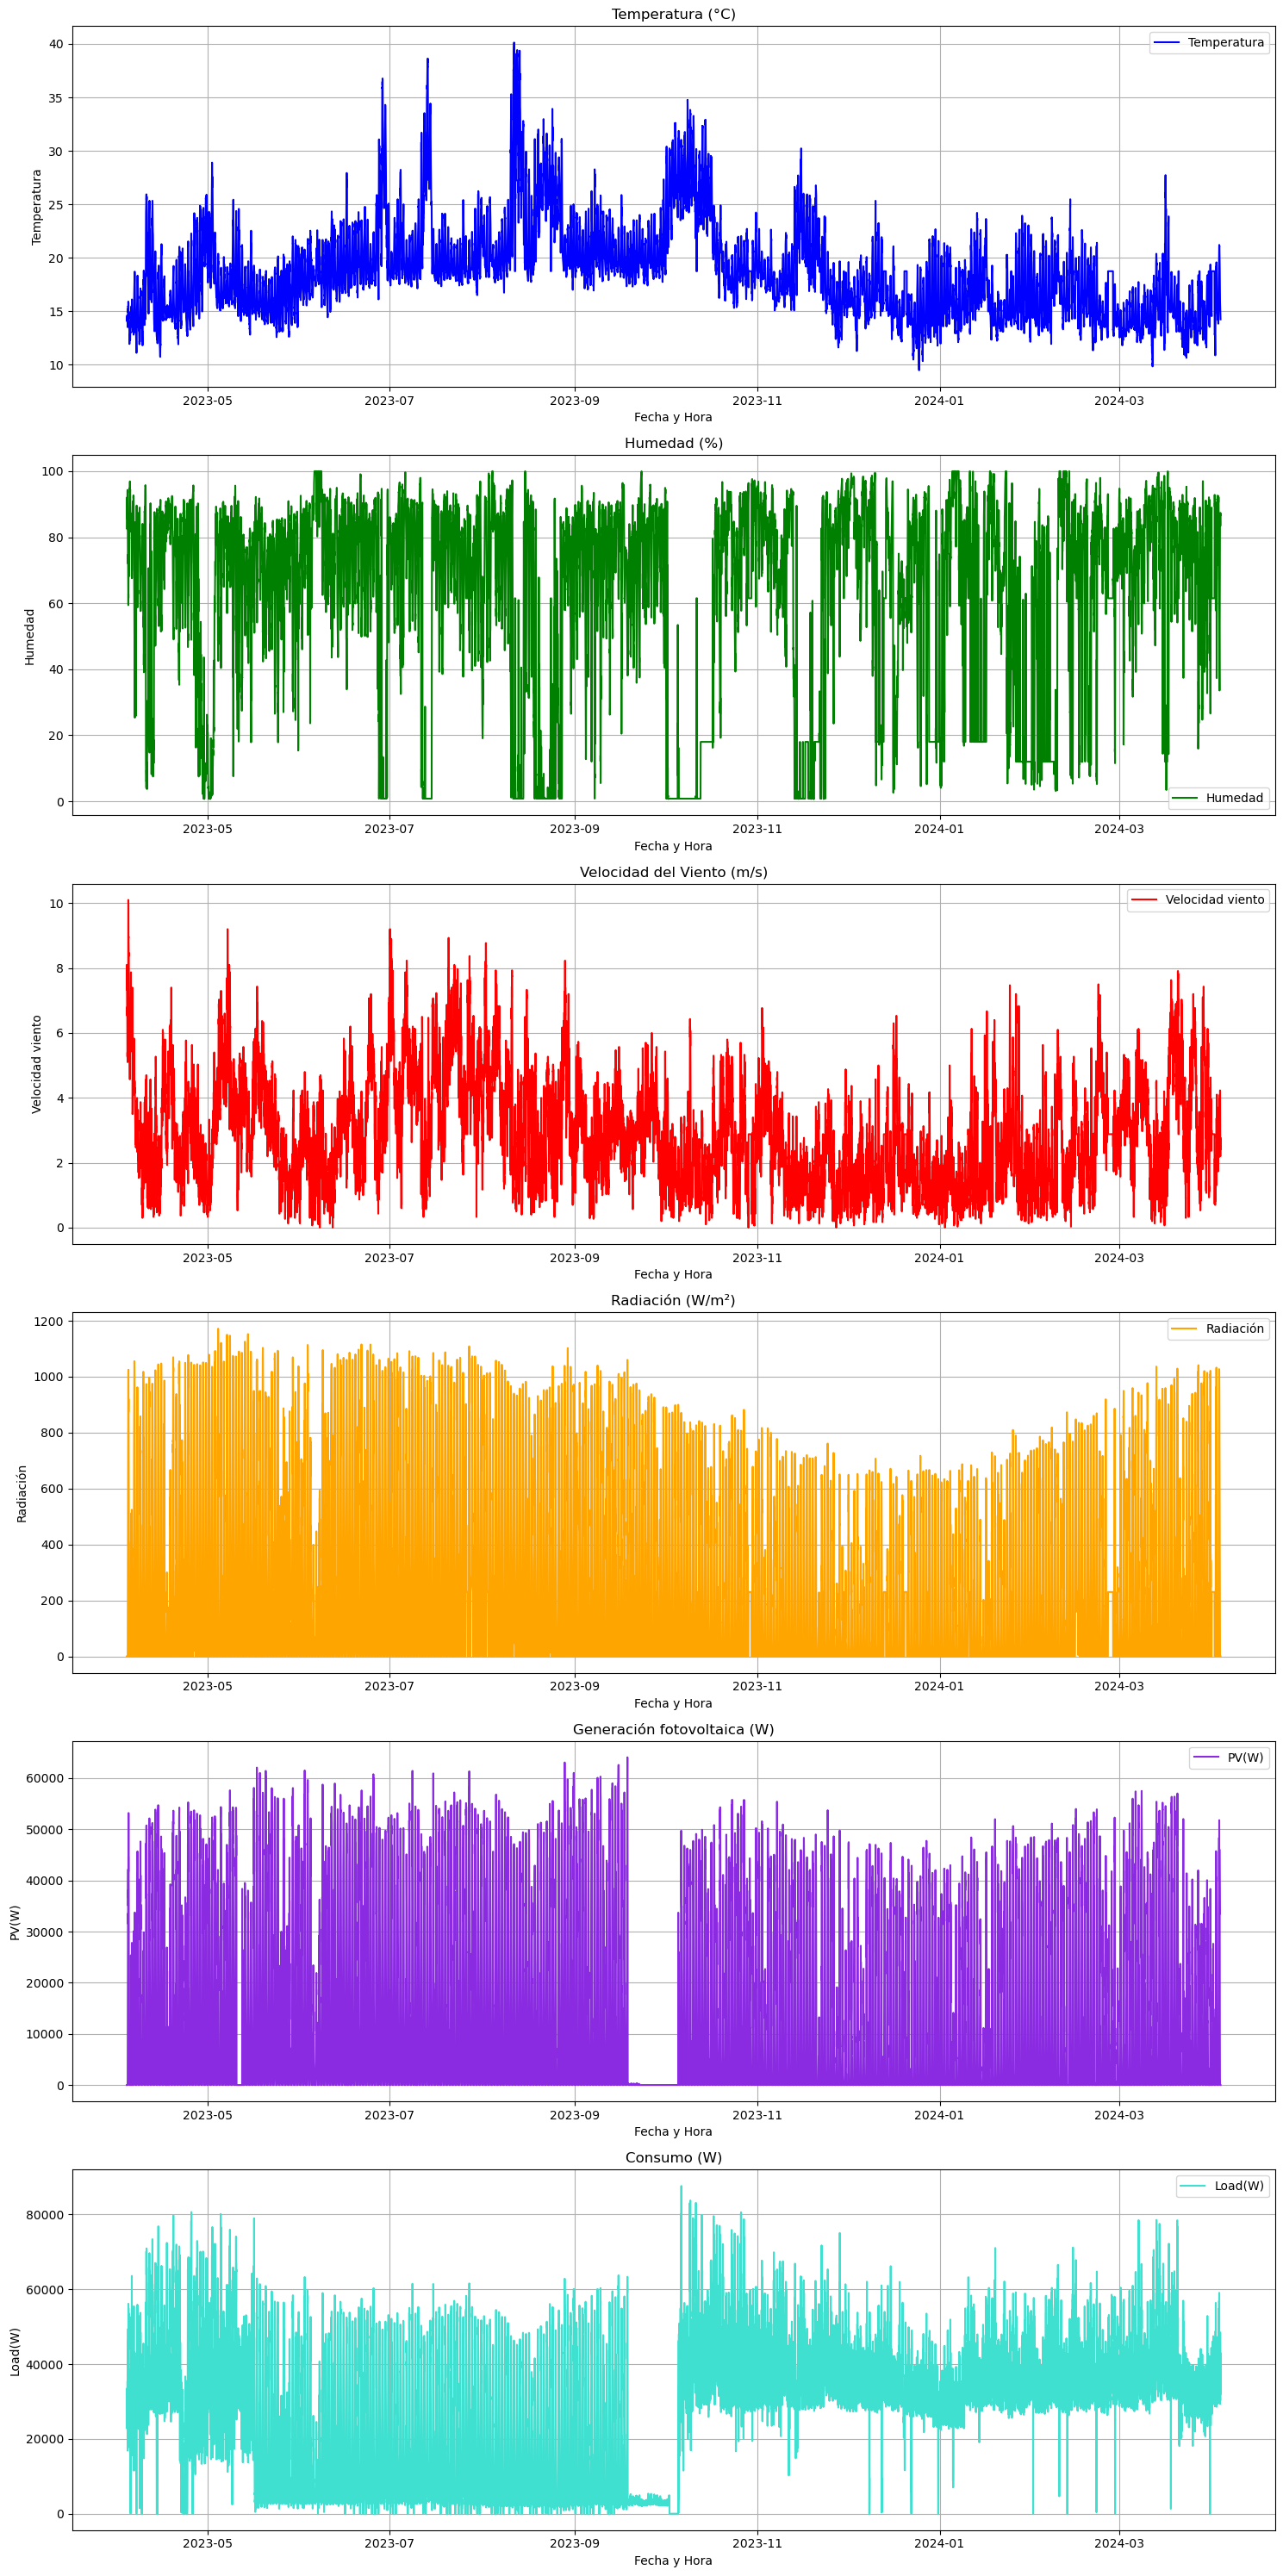

In [23]:
import matplotlib.pyplot as plt

# Asumiendo que 'combined_data' es el DataFrame y ya está cargado correctamente.

# Configuración de la figura para múltiples subgráficos (ahora 6 subgráficos en lugar de 4)
fig, axs = plt.subplots(6, 1, figsize=(15, 30))  # Ajuste la cantidad de subgráficos a 6

# Títulos para los gráficos
titles = ['Temperatura (°C)', 'Humedad (%)', 'Velocidad del Viento (m/s)', 
          'Radiación (W/m²)', 'Generación fotovoltaica (W)', 'Consumo (W)']

# Variables a graficar
variables = ['Temperatura', 'Humedad', 'Velocidad viento', 'Radiación', 'PV(W)', 'Load(W)']

# Colores para cada gráfico
colors = ['blue', 'green', 'red', 'orange', 'blueviolet', 'turquoise']

# Usar 'combined_data.index' si 'Fecha y hora' es el índice del DataFrame
for i, var in enumerate(variables):
    axs[i].plot(combined_data.index, combined_data[var], color=colors[i], label=var)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Fecha y Hora')
    axs[i].set_ylabel(var)
    axs[i].legend()
    axs[i].grid(True)

# Mejorar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()
